In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from __future__ import division, print_function, absolute_import

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

First we load the mnist dataset. We only need the images (from both the train and test set) for the autoencoder. 

In [2]:
from keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = 2*x_train -1
x_test = 2*x_test -1

Using TensorFlow backend.


#Build the graph
We build the GAN network. We make two Sequential models for the discriminator and the generator. 

In [3]:
from tensorflow.keras.optimizers import Adam

discriminator_optimizer = Adam(3e-5)
adversarial_optimizer = Adam(3e-5)
generator_optimizer = Adam(3e-5)

dropout = 0.2
latent_num = 100
w_stddev = 0.005

def w_init(stddev):
    return keras.initializers.RandomNormal(mean=0.0, stddev=stddev)

def dense(units, **kargs):
    return keras.layers.Dense(
        units=units,
        kernel_initializer=w_init(w_stddev),
        bias_initializer=w_init(w_stddev),
        **kargs)
                       
# discriminator 
discriminator = keras.models.Sequential(name="discriminator_net")
discriminator.add(keras.layers.Input(shape=(28,28)))
discriminator.add(keras.layers.Flatten(name="flattened_input"))
discriminator.add(keras.layers.Dropout(dropout))
discriminator.add(dense(units=1024, name="dL1"))
discriminator.add(keras.layers.ReLU())
discriminator.add(keras.layers.Dropout(dropout))
discriminator.add(dense(512, name="dL2"))
discriminator.add(keras.layers.ReLU())
discriminator.add(keras.layers.Dropout(dropout))
discriminator.add(dense(256, name="dL3"))
discriminator.add(keras.layers.ReLU())
discriminator.add(keras.layers.Dropout(dropout))
discriminator.add(dense(1, activation="sigmoid", name="prob"))

# generator
generator = keras.models.Sequential(name="generator_net")
generator.add(keras.layers.Input(shape=(latent_num,)))
generator.add(dense(256, name="gL1"))
generator.add(keras.layers.ReLU())
generator.add(dense(512, name="gL2"))
generator.add(keras.layers.ReLU())
generator.add(dense(1024,  name="gL3"))
generator.add(keras.layers.ReLU())
generator.add(dense(28*28,  name="output"))
generator.add(keras.layers.Reshape((28, 28), name="unflattened_output"))

input_images = discriminator.input
generated_patterns = generator.input

discriminator.trainable = True
generator.trainable = False
discriminator_model = keras.models.Model(name="discriminator",
    inputs=input_images, outputs=discriminator(input_images))
discriminator_model.compile(optimizer=discriminator_optimizer,
                            loss='binary_crossentropy')

discriminator.trainable = False
generator.trainable = True  
generated_images = generator(generated_patterns)
adversarial_model = keras.models.Model(name="adversarial",
    inputs=generated_patterns, outputs=discriminator(generated_images))
adversarial_model.compile(optimizer=adversarial_optimizer,
                          loss='binary_crossentropy')

generator_model = keras.models.Model(name="generator",
    inputs=generated_patterns, outputs=generated_images)
generator_model.compile(optimizer=generator_optimizer,
                        loss='binary_crossentropy')

discriminator.summary()
generator.summary()
discriminator_model.summary()
adversarial_model.summary()
generator_model.summary()

W0821 03:19:49.456899 140084003055360 deprecation.py:506] From /home/fmannella/venv3/lib/python3.5/site-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0821 03:19:49.653791 140084003055360 deprecation.py:323] From /home/fmannella/venv3/lib/python3.5/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0821 03:19:49.809208 140084003055360 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Model: "discriminator_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flattened_input (Flatten)    (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dL1 (Dense)                  (None, 1024)              803840    
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dL2 (Dense)                  (None, 512)               524800    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 512)         

In [4]:
num_epochs  = 3000
batch_size = 30
epochs_to_show = 20

img_indices = np.arange(x_train.shape[0])
num_imgs = len(img_indices)
batch_num = num_imgs//batch_size

def noise(size):
    x = np.random.normal(0,1, [size, latent_num])
    return x

noise_test = noise(25)

epoch: 0 dloss: 0.6341234  aloss: 0.7342281 


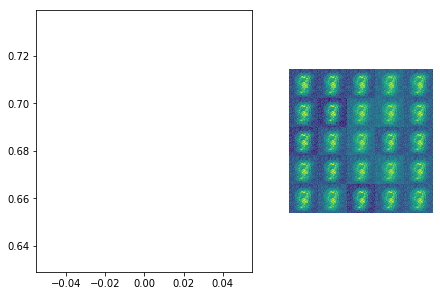

KeyboardInterrupt: 

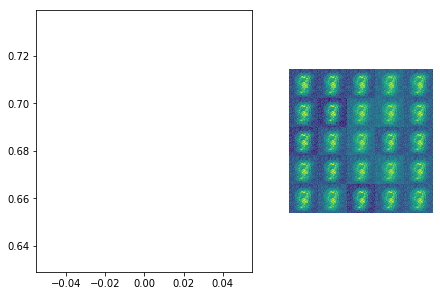

In [5]:
%matplotlib inline
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

dloss = []
aloss = []
curr_dloss = 0.0
curr_aloss = 0.0
for epoch in range(num_epochs):
    np.random.shuffle(img_indices)
    train_imgs = x_train[img_indices,...]
    epoch_dloss = [] 
    epoch_aloss = [] 
    for batch in range(batch_num):
        curr_batch = train_imgs[batch*batch_size:(batch + 1)*batch_size]
        discr_gen = noise(batch_size)
        discr_gen_batch = generator_model.predict(discr_gen)


        discriminator.trainable = True
        generator.trainable = False
        curr_dloss = discriminator_model.train_on_batch(
            np.vstack((curr_batch, discr_gen_batch)), 
            np.hstack((np.ones(batch_size), np.zeros(batch_size))))

        discriminator.trainable = False
        generator.trainable = True   
        adv_gen = noise(batch_size)
        curr_aloss = adversarial_model.train_on_batch(
            adv_gen, 
            np.ones(batch_size))

        epoch_dloss.append(curr_dloss)
        epoch_aloss.append(curr_aloss)
        
    dloss.append(np.mean(epoch_dloss))
    aloss.append(np.mean(epoch_aloss))
    
    if epoch%epochs_to_show == 0 or epoch == (num_epochs - 1):
        
        fig = plt.figure(figsize=(10,3), constrained_layout=True)
        gs = fig.add_gridspec(1, 5)
        
        ax1 = fig.add_subplot(gs[:,:-2])
        ax1.plot(dloss, c="red")
        ax1.plot(aloss, c="green")

        test_gen_batch = generator_model.predict(noise_test).reshape(5,5,28,28)
        ax2 = fig.add_subplot(gs[:,-2:], aspect="auto")
        ax2.imshow(np.vstack([
                              np.hstack([img for img in test_gen_row])
                              for test_gen_row in test_gen_batch]))
        ax2.set_axis_off()
        display.clear_output(wait=True)
        print("epoch: %d dloss: %-10.7f aloss: %-10.7f" % (
            epoch, dloss[-1], aloss[-1]))
      
        display.display(plt.gcf())
        